### Titanic – Error Analysis Dashboard

This notebook trains a baseline model, generates validation predictions, 
and provides a dashboard to explore **false positives** and **false negatives**.


In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
)

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 4)

DATA_DIR = "../data/processed_v2"
REPORTS_DIR = "../reports/errors"
os.makedirs(REPORTS_DIR, exist_ok=True)

In [2]:
# ============================================================
# 1. Load processed datasets
# ============================================================

train = pd.read_csv(f"{DATA_DIR}/train_features.csv")
test = pd.read_csv(f"{DATA_DIR}/test_features.csv")

# We'll keep PassengerId around for reference
train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeMissing,...,TicketGroupSize,TicketGroupFarePerPerson,AgeBand,FareBand,Sex_Pclass,Sex_AgeBand,Embarked_Pclass,Title_AgeBand,Pclass_FareBand,Survived
0,1,3,male,22.0,1,0,7.2500,S,Mr,0,...,1,7.2500,"(20.0, 25.0]","(-0.001, 7.854]",male_3,"male_(20.0, 25.0]",S_3,"Mr_(20.0, 25.0]","3_(-0.001, 7.854]",0
1,2,1,female,38.0,1,0,71.2833,C,Mrs,0,...,1,71.2833,"(30.0, 40.0]","(39.688, 512.329]",female_1,"female_(30.0, 40.0]",C_1,"Mrs_(30.0, 40.0]","1_(39.688, 512.329]",1
2,3,3,female,26.0,0,0,7.9250,S,Miss,0,...,1,7.9250,"(25.0, 30.0]","(7.854, 10.5]",female_3,"female_(25.0, 30.0]",S_3,"Miss_(25.0, 30.0]","3_(7.854, 10.5]",1
3,4,1,female,35.0,1,0,53.1000,S,Mrs,0,...,2,26.5500,"(30.0, 40.0]","(39.688, 512.329]",female_1,"female_(30.0, 40.0]",S_1,"Mrs_(30.0, 40.0]","1_(39.688, 512.329]",1
4,5,3,male,35.0,0,0,8.0500,S,Mr,0,...,1,8.0500,"(30.0, 40.0]","(7.854, 10.5]",male_3,"male_(30.0, 40.0]",S_3,"Mr_(30.0, 40.0]","3_(7.854, 10.5]",0


In [3]:
# ============================================================
# 2. Identify feature columns
# ============================================================

y = train["Survived"]
X = train.drop(columns=["Survived", "PassengerId"])
X_test_final = test.drop(columns=["PassengerId"])

with open(f"{DATA_DIR}/processed_metadata.json", "r") as f:
    meta = json.load(f)

categorical_cols = list(meta.keys())
numeric_cols = [col for col in X.columns if col not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

Categorical columns: ['Sex', 'Embarked', 'Title', 'TicketPrefix', 'CabinDeck', 'AgeBand', 'FareBand', 'Sex_Pclass', 'Sex_AgeBand', 'Embarked_Pclass', 'Title_AgeBand', 'Pclass_FareBand']
Numeric columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'AgeMissing', 'FareMissing', 'CabinKnown', 'FamilySize', 'IsAlone', 'LogFare', 'FarePerPerson', 'TicketGroupSize', 'TicketGroupFarePerPerson']


In [8]:
# ============================================================
# 3. Preprocessing: One-Hot + Scaling
# ============================================================

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

# ============================================================
# 4. Logistic Regression pipeline (baseline model)
# ============================================================

logreg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("logreg", LogisticRegression(max_iter=2000)),
    ]
)

In [9]:
# ============================================================
# 5. Train/validation split
# ============================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_val.shape

((712, 26), (179, 26))

In [10]:
# ============================================================
# 6. Fit baseline model & predict on validation set
# ============================================================

logreg_pipeline.fit(X_train, y_train)

y_val_pred = logreg_pipeline.predict(X_val)
y_val_proba = logreg_pipeline.predict_proba(X_val)[:, 1]

print("ROC AUC:", roc_auc_score(y_val, y_val_proba))
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred))

ROC AUC: 0.8648221343873517

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       110
           1       0.80      0.77      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



In [11]:
# ============================================================
# 7. Assemble validation results table
# ============================================================

val_results = X_val.copy()
val_results["y_true"] = y_val.values
val_results["y_pred"] = y_val_pred
val_results["y_proba"] = y_val_proba

# Add an error_type label: TP, FP, FN, TN
def label_error(row):
    if row["y_true"] == 1 and row["y_pred"] == 1:
        return "TP"
    elif row["y_true"] == 0 and row["y_pred"] == 0:
        return "TN"
    elif row["y_true"] == 0 and row["y_pred"] == 1:
        return "FP"
    else:
        return "FN"

val_results["error_type"] = val_results.apply(label_error, axis=1)

val_results.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeMissing,TicketPrefix,...,FareBand,Sex_Pclass,Sex_AgeBand,Embarked_Pclass,Title_AgeBand,Pclass_FareBand,y_true,y_pred,y_proba,error_type
565,3,male,24.0,2,0,24.1500,S,Mr,0,A,...,"(21.679, 39.688]",male_3,"male_(20.0, 25.0]",S_3,"Mr_(20.0, 25.0]","3_(21.679, 39.688]",0,0,0.021382,TN
160,3,male,44.0,0,1,16.1000,S,Mr,0,NONE,...,"(10.5, 21.679]",male_3,"male_(40.0, 80.0]",S_3,"Mr_(40.0, 80.0]","3_(10.5, 21.679]",0,0,0.075280,TN
553,3,male,22.0,0,0,7.2250,C,Mr,0,NONE,...,"(-0.001, 7.854]",male_3,"male_(20.0, 25.0]",C_3,"Mr_(20.0, 25.0]","3_(-0.001, 7.854]",1,0,0.118466,FN
860,3,male,41.0,2,0,14.1083,S,Mr,0,NONE,...,"(10.5, 21.679]",male_3,"male_(40.0, 80.0]",S_3,"Mr_(40.0, 80.0]","3_(10.5, 21.679]",0,0,0.036992,TN
241,3,female,21.5,1,0,15.5000,Q,Miss,1,NONE,...,"(10.5, 21.679]",female_3,"female_(20.0, 25.0]",Q_3,"Miss_(20.0, 25.0]","3_(10.5, 21.679]",1,1,0.638367,TP


In [12]:
val_results_path = f"{REPORTS_DIR}/logreg_val_results.csv"
val_results.to_csv(val_results_path, index=False)
print("Saved validation results to:", val_results_path)

Saved validation results to: ../reports/errors/logreg_val_results.csv


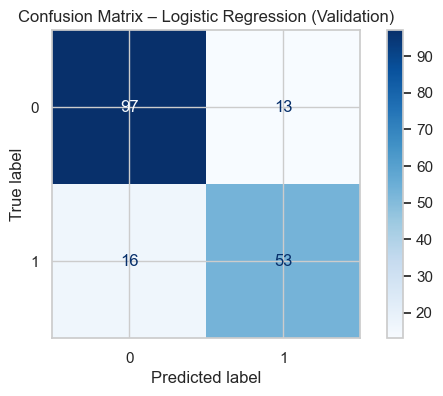

error_type
TN    97
TP    53
FN    16
FP    13
Name: count, dtype: int64

In [13]:
# ============================================================
# 8. Confusion matrix & error counts
# ============================================================

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression (Validation)")
plt.show()

val_results["error_type"].value_counts()

In [14]:
# ============================================================
# 9. Define convenience slices for error groups
# ============================================================

fp = val_results[val_results["error_type"] == "FP"]
fn = val_results[val_results["error_type"] == "FN"]
tp = val_results[val_results["error_type"] == "TP"]
tn = val_results[val_results["error_type"] == "TN"]

print(f"FP: {len(fp)}, FN: {len(fn)}, TP: {len(tp)}, TN: {len(tn)}")

FP: 13, FN: 16, TP: 53, TN: 97


In [15]:
# ============================================================
# 10. Error breakdown by key categorical features
# ============================================================

def error_breakdown_by(feature, top_n=None):
    """Show counts and proportions of error types for a given feature."""
    tbl = (
        val_results
        .groupby([feature, "error_type"])
        .size()
        .unstack(fill_value=0)
    )
    tbl["Total"] = tbl.sum(axis=1)
    for col in ["TP", "FP", "FN", "TN"]:
        if col in tbl.columns:
            tbl[col + "_pct"] = tbl[col] / tbl["Total"]
    if top_n:
        tbl = tbl.sort_values("Total", ascending=False).head(top_n)
    return tbl

for feat in ["Pclass", "Sex", "Embarked", "Title", "CabinDeck"]:
    if feat in val_results.columns:
        print(f"\n=== Error breakdown by {feat} ===")
        display(error_breakdown_by(feat))


=== Error breakdown by Pclass ===


error_type,FN,FP,TN,TP,Total,TP_pct,FP_pct,FN_pct,TN_pct
Pclass,,,,,,,,,
1,7,6,14,18,45,0.400000,0.133333,0.155556,0.311111
2,2,1,13,18,34,0.529412,0.029412,0.058824,0.382353
3,7,6,70,17,100,0.170000,0.060000,0.070000,0.700000



=== Error breakdown by Sex ===


error_type,FN,FP,TN,TP,Total,TP_pct,FP_pct,FN_pct,TN_pct
Sex,,,,,,,,,
female,0,7,9,45,61,0.737705,0.114754,0.000000,0.147541
male,16,6,88,8,118,0.067797,0.050847,0.135593,0.745763



=== Error breakdown by Embarked ===


error_type,FN,FP,TN,TP,Total,TP_pct,FP_pct,FN_pct,TN_pct
Embarked,,,,,,,,,
C,5,2,12,10,29,0.344828,0.068966,0.172414,0.413793
Q,0,4,12,6,22,0.272727,0.181818,0.000000,0.545455
S,11,7,73,37,128,0.289062,0.054688,0.085938,0.570312



=== Error breakdown by Title ===


error_type,FN,FP,TN,TP,Total,TP_pct,FP_pct,FN_pct,TN_pct
Title,,,,,,,,,
Master,1,1,2,5,9,0.555556,0.111111,0.111111,0.222222
Miss,0,6,7,28,41,0.682927,0.146341,0.000000,0.170732
Mr,15,3,84,3,105,0.028571,0.028571,0.142857,0.800000
Mrs,0,1,2,16,19,0.842105,0.052632,0.000000,0.105263
Rare,0,2,2,1,5,0.200000,0.400000,0.000000,0.400000



=== Error breakdown by CabinDeck ===


error_type,FN,FP,TN,TP,Total,TP_pct,FP_pct,FN_pct,TN_pct
CabinDeck,,,,,,,,,
A,0,0,0,1,1,1.000000,0.000000,0.000000,0.000000
B,3,2,1,7,13,0.538462,0.153846,0.230769,0.076923
C,2,3,8,5,18,0.277778,0.166667,0.111111,0.444444
D,0,1,2,4,7,0.571429,0.142857,0.000000,0.285714
E,0,0,1,2,3,0.666667,0.000000,0.000000,0.333333
F,0,0,2,0,2,0.000000,0.000000,0.000000,1.000000
Unknown,11,7,83,34,135,0.251852,0.051852,0.081481,0.614815


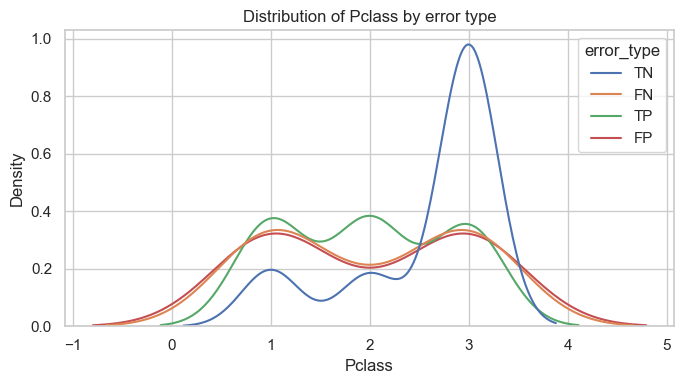

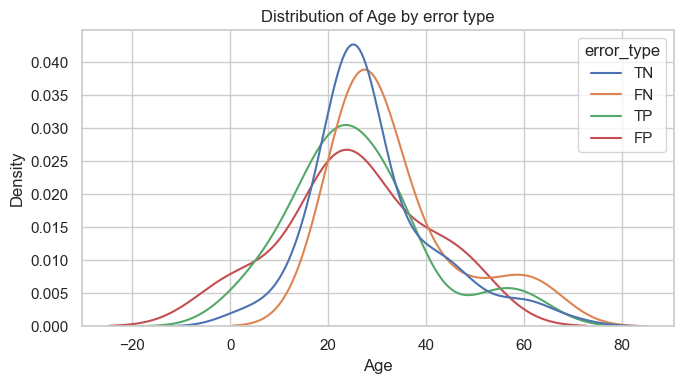

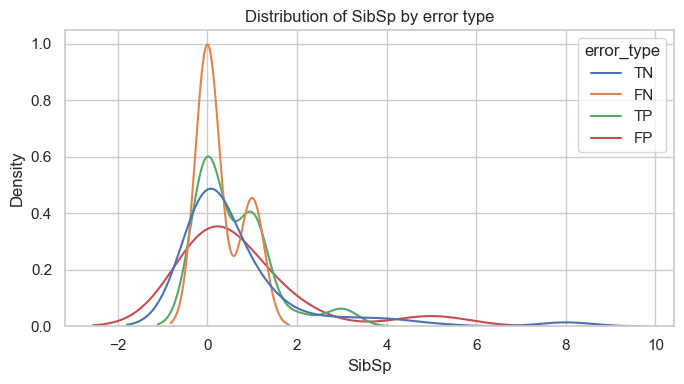

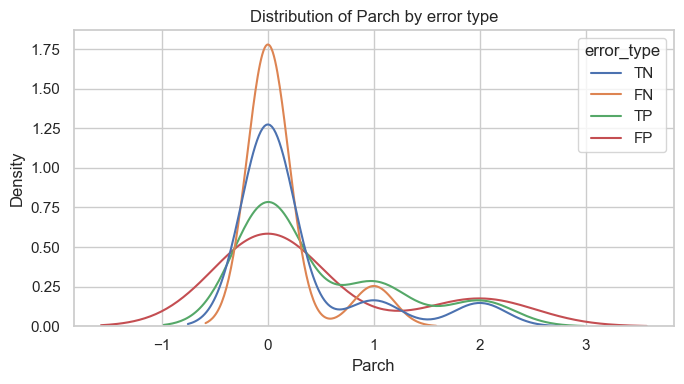

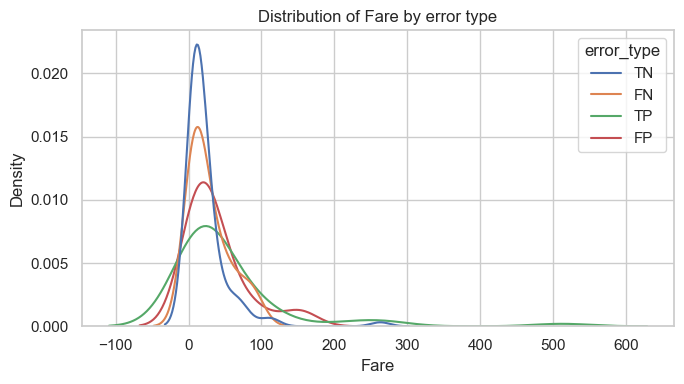

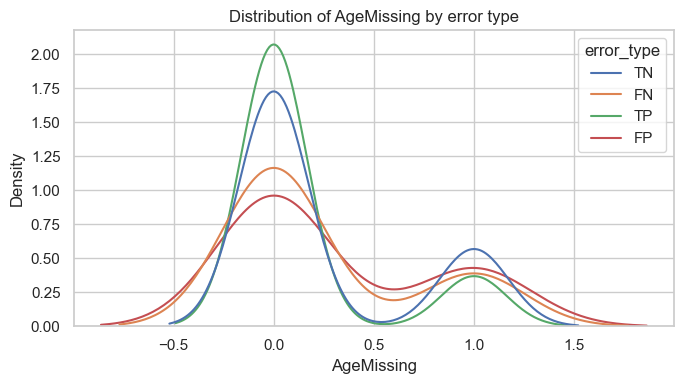

C:\Users\agbro\AppData\Local\Temp\ipykernel_24548\2920846368.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=val_results, x=feature, hue="error_type", common_norm=False)


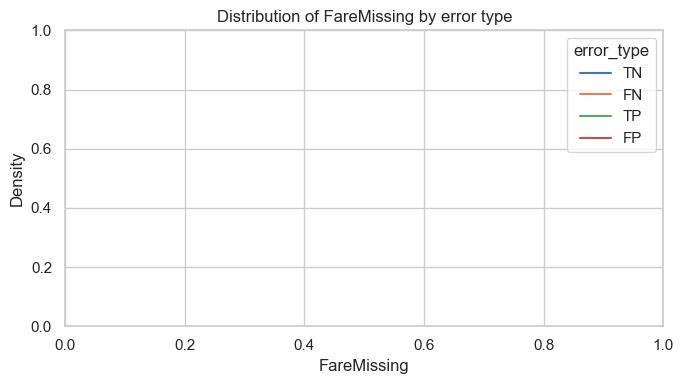

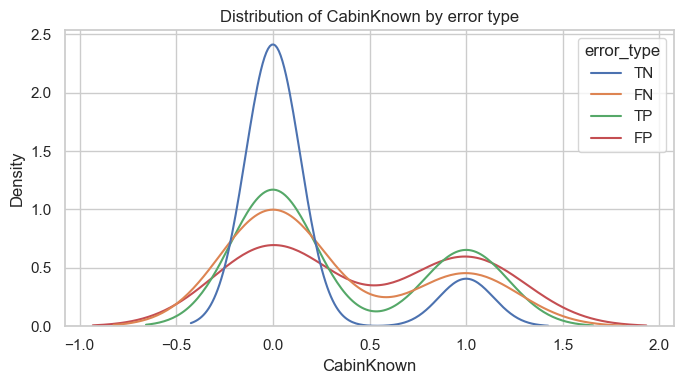

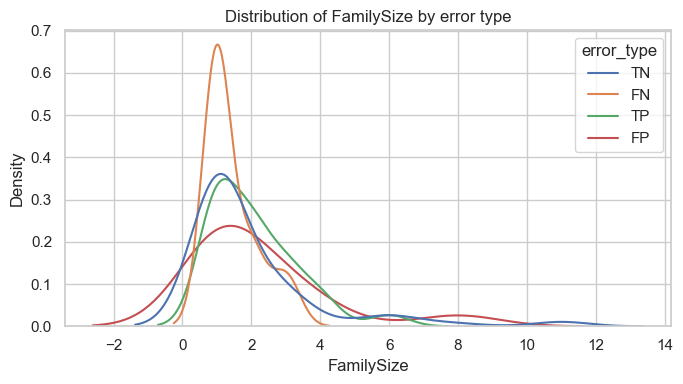

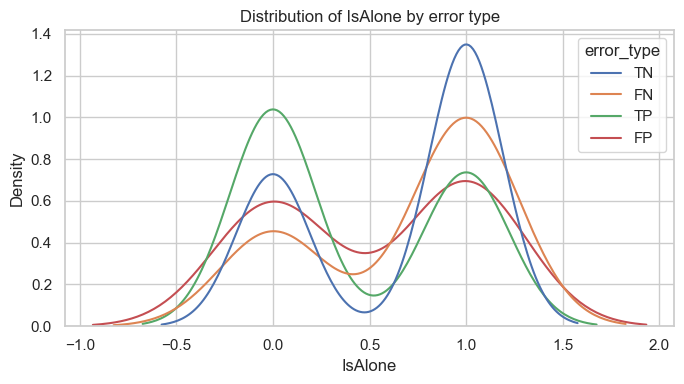

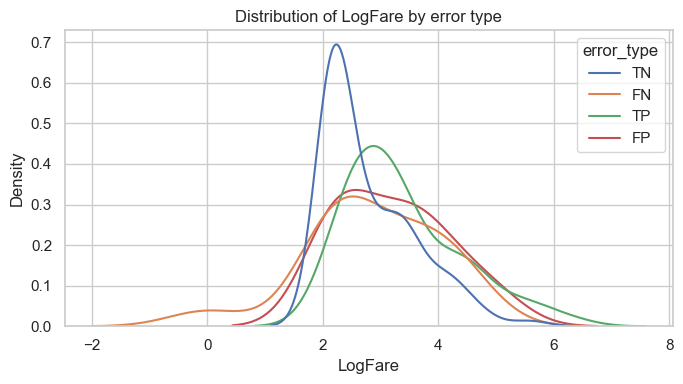

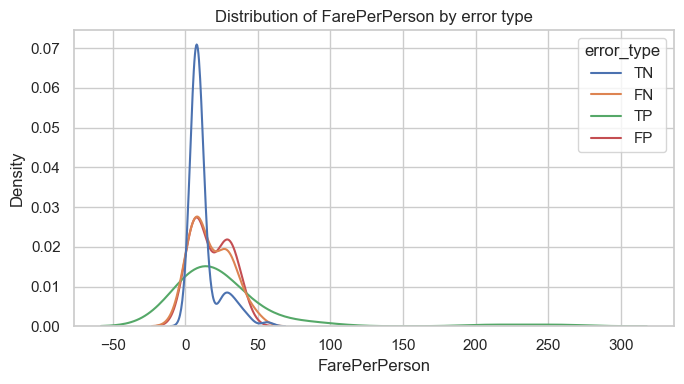

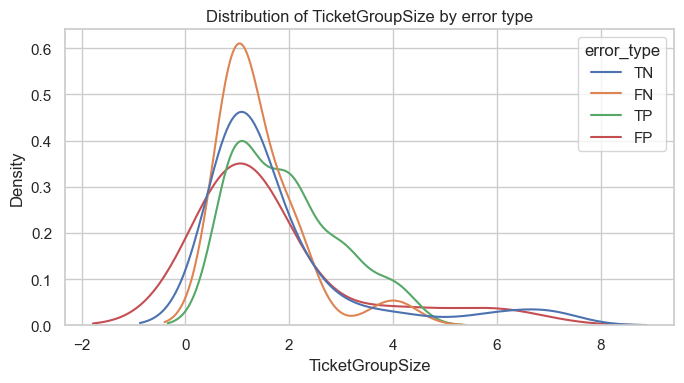

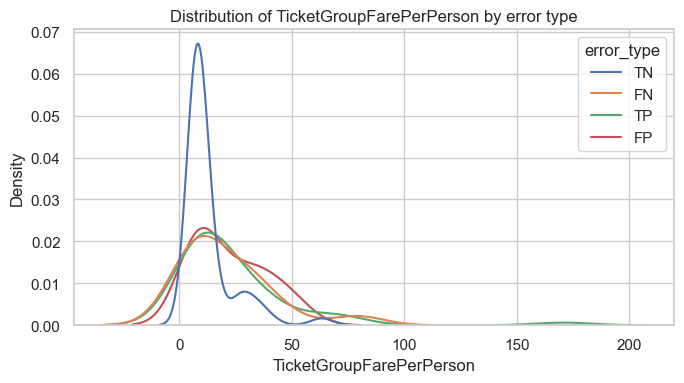

In [16]:
# ============================================================
# 11. Numeric feature distributions by error type
# ============================================================

def compare_numeric_distribution(feature):
    plt.figure(figsize=(7,4))
    sns.kdeplot(data=val_results, x=feature, hue="error_type", common_norm=False)
    plt.title(f"Distribution of {feature} by error type")
    plt.tight_layout()
    plt.show()

for col in numeric_cols:
    if col in val_results.columns:
        compare_numeric_distribution(col)

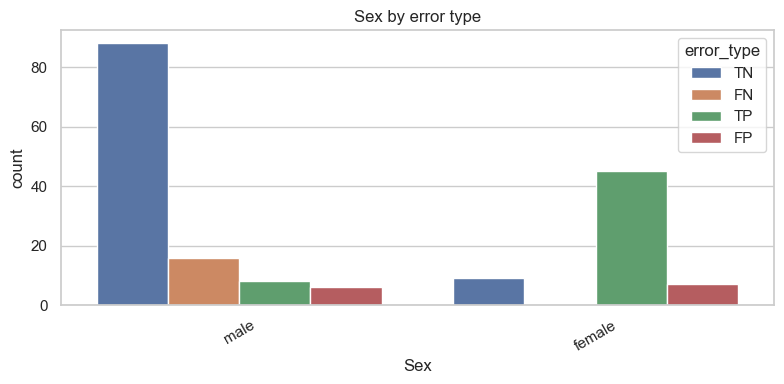

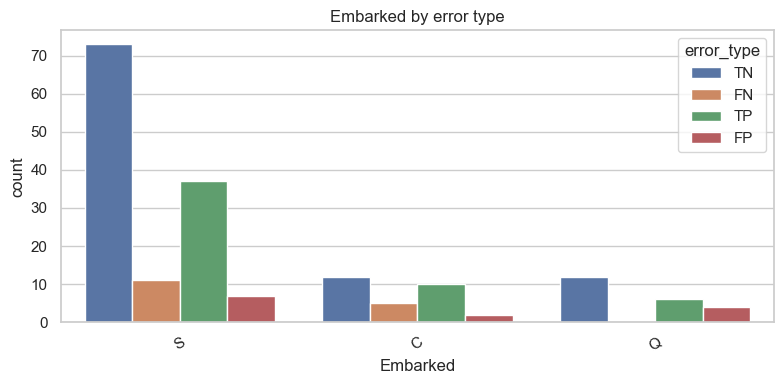

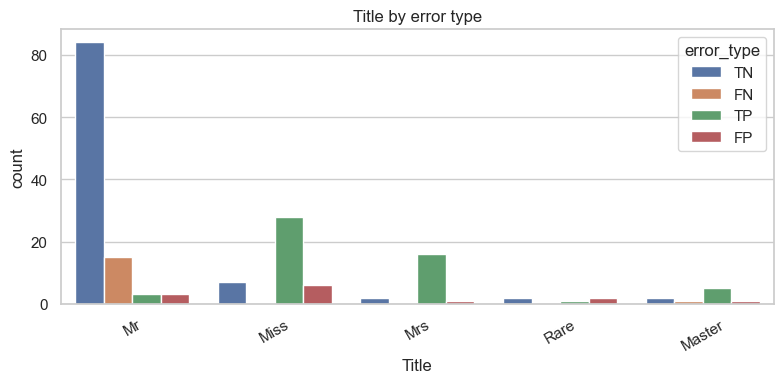

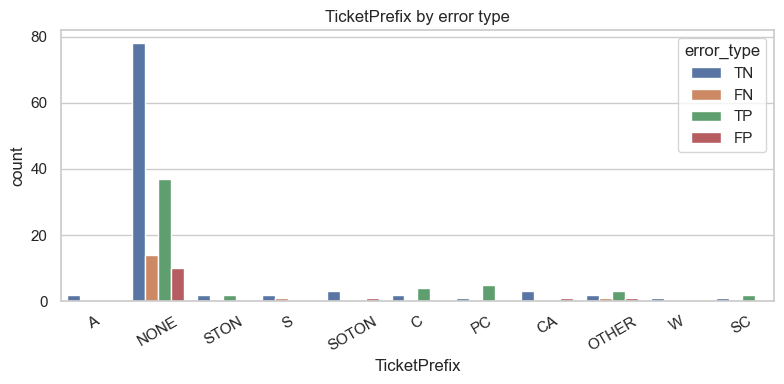

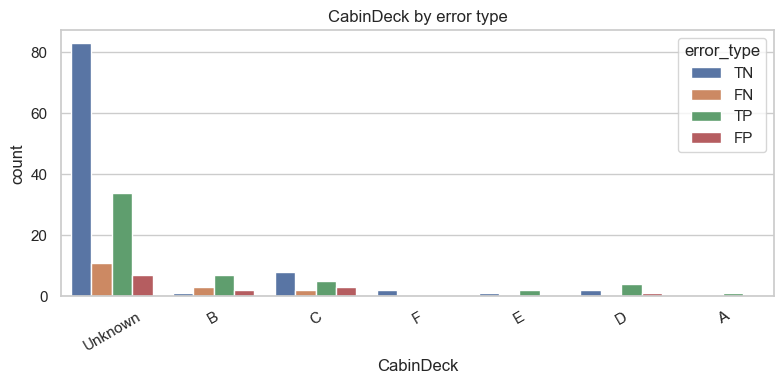

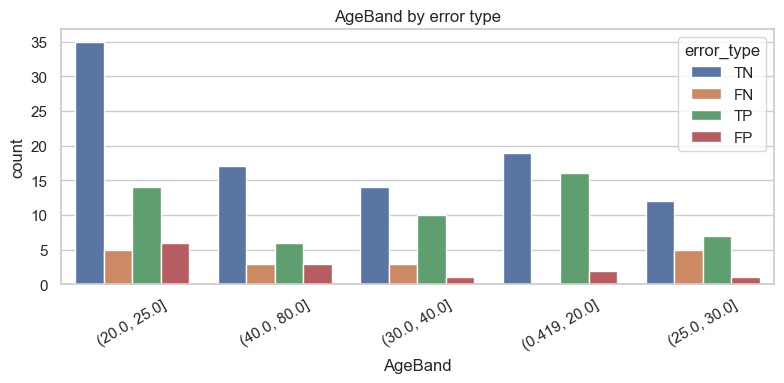

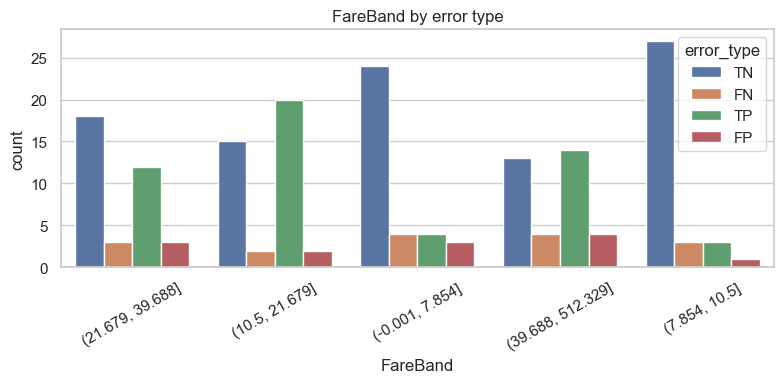

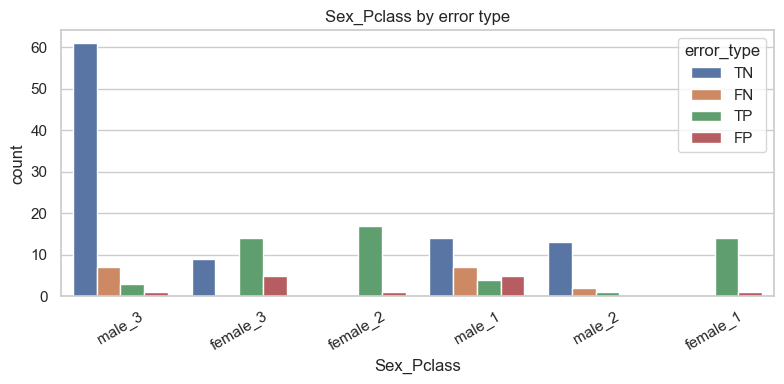

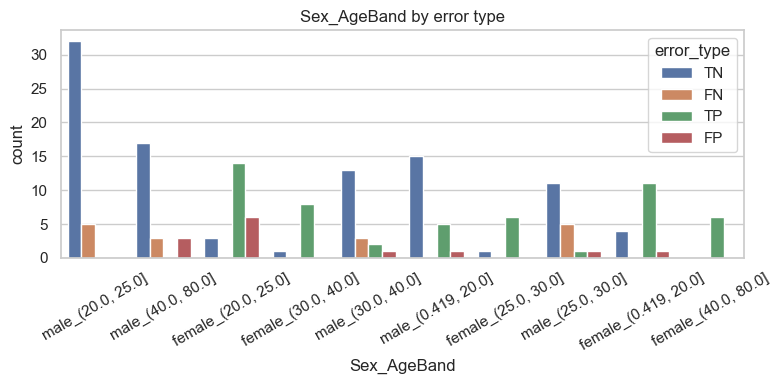

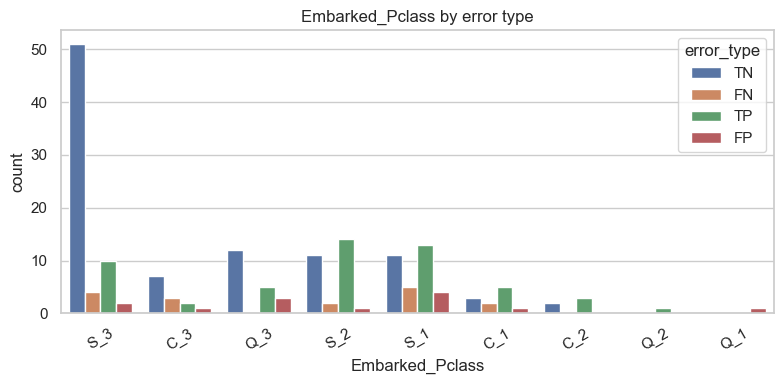

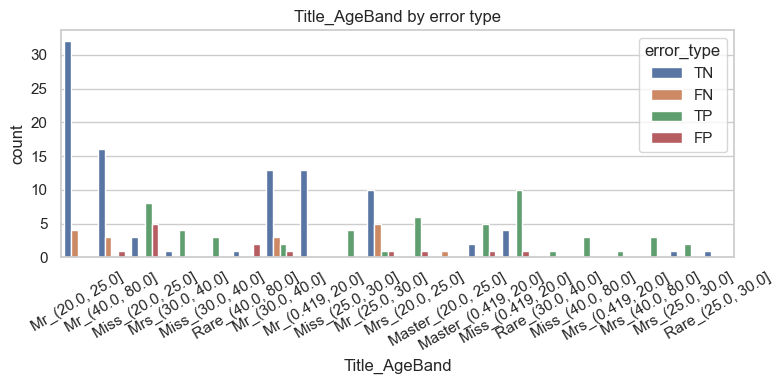

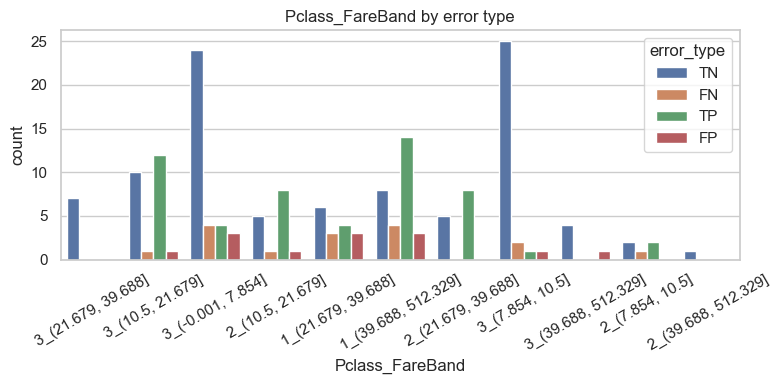

In [17]:
# ============================================================
# 12. Categorical feature distributions by error type
# ============================================================

def plot_categorical_error(feature):
    plt.figure(figsize=(8,4))
    sns.countplot(data=val_results, x=feature, hue="error_type")
    plt.title(f"{feature} by error type")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

for col in categorical_cols:
    if col in val_results.columns:
        plot_categorical_error(col)

In [19]:
errors_only = val_results[val_results["error_type"].isin(["FP", "FN"])]

In [22]:
def plot_categorical_error(feature):
    plt.figure(figsize=(8,4))
    sns.countplot(
        data=errors_only,
        x=feature,
        hue="error_type",
    )
    plt.title(f"{feature} — FP vs FN")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

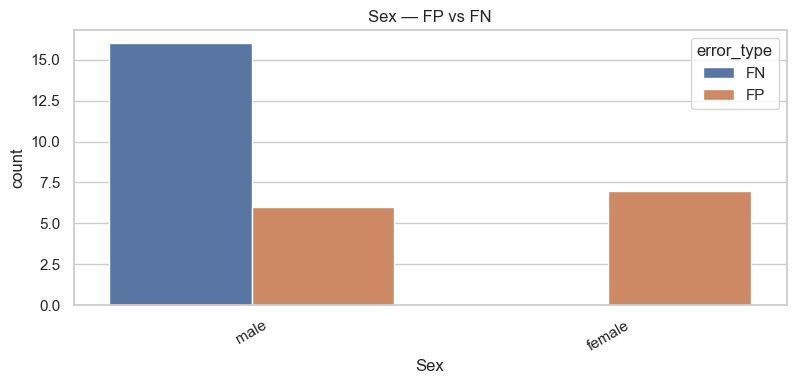

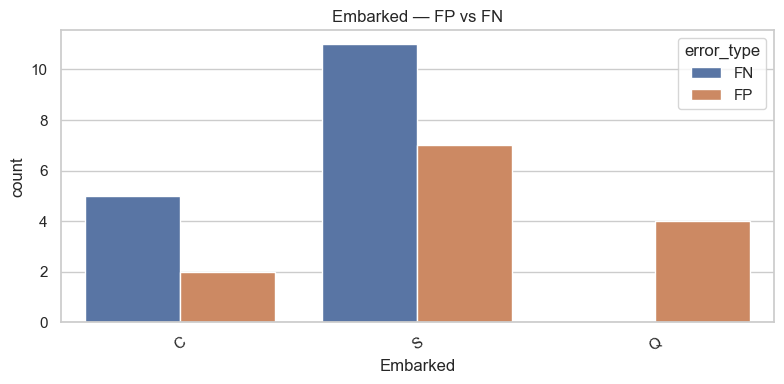

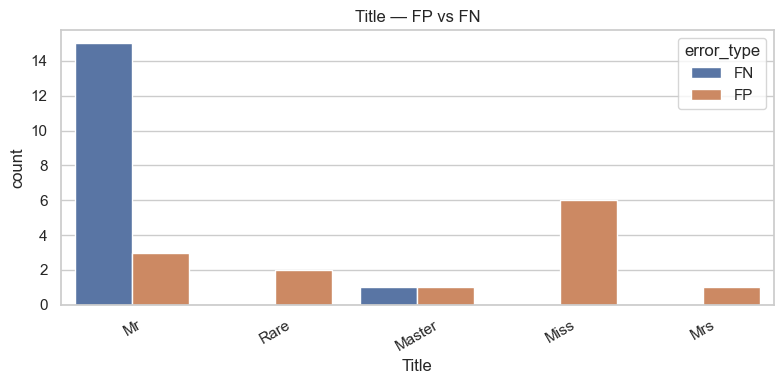

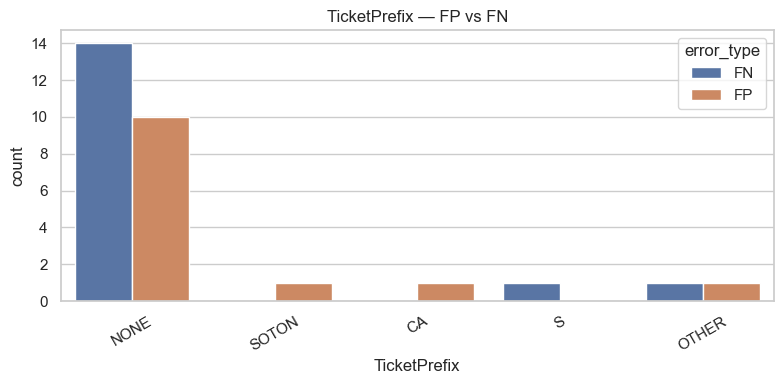

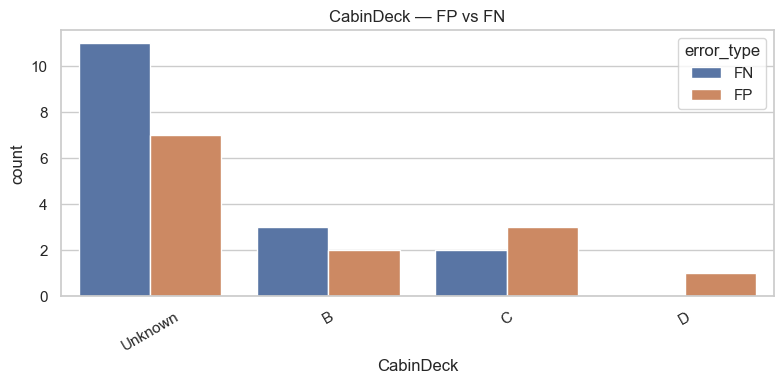

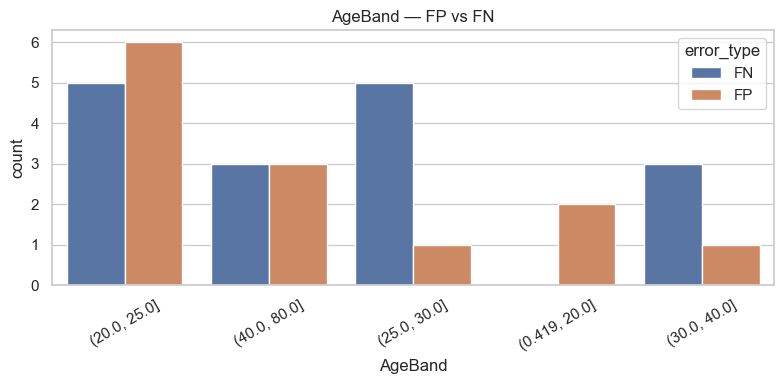

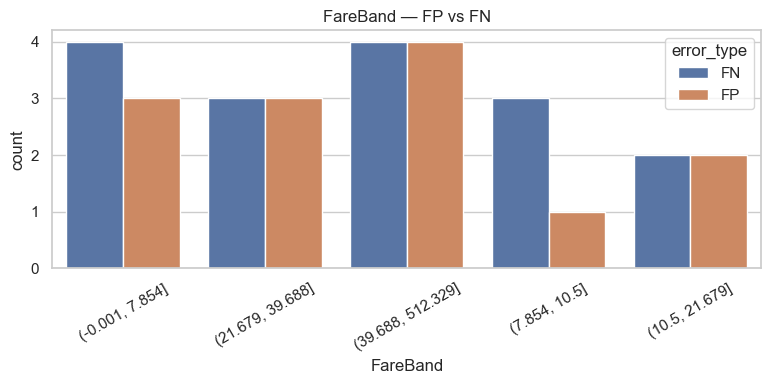

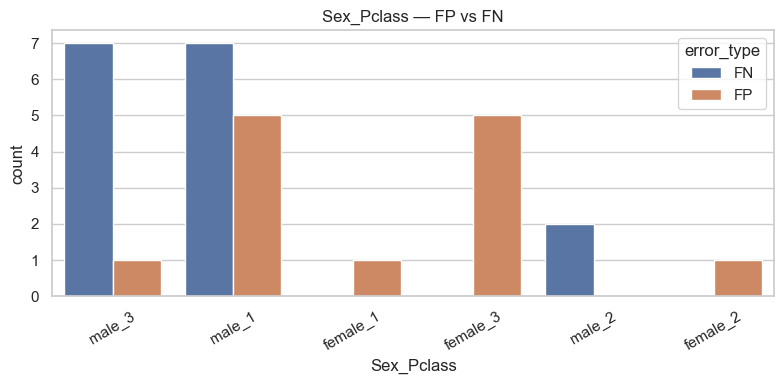

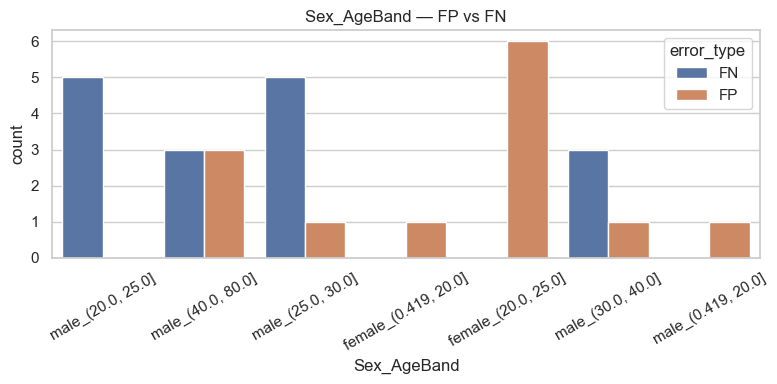

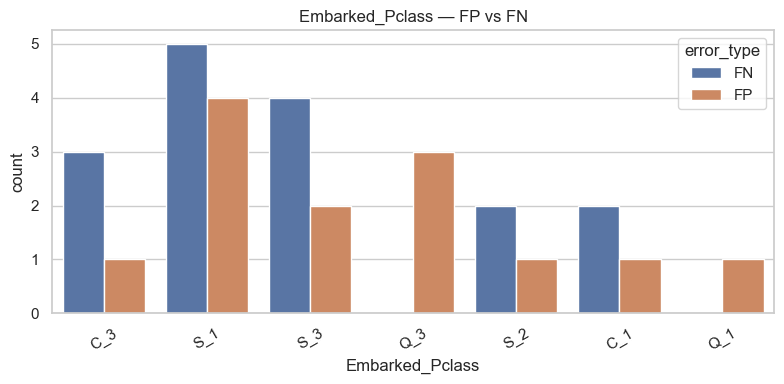

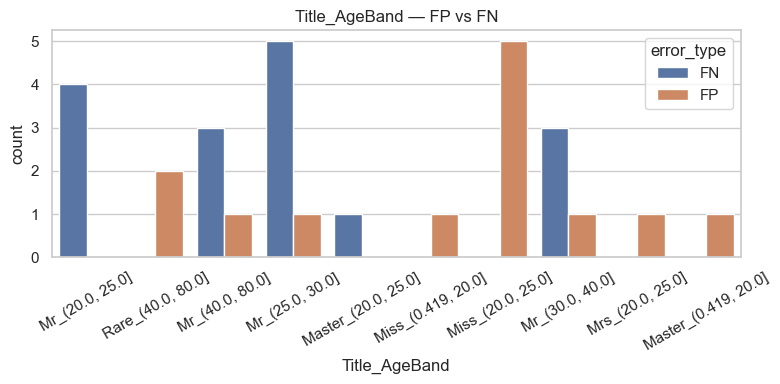

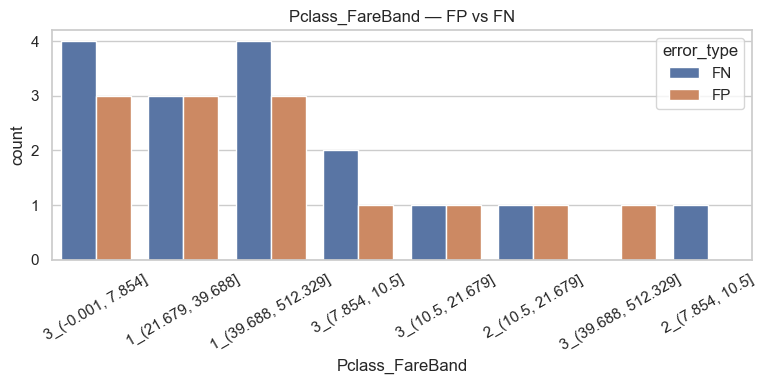

In [23]:
for col in categorical_cols:
    if col in errors_only.columns:
        plot_categorical_error(col)

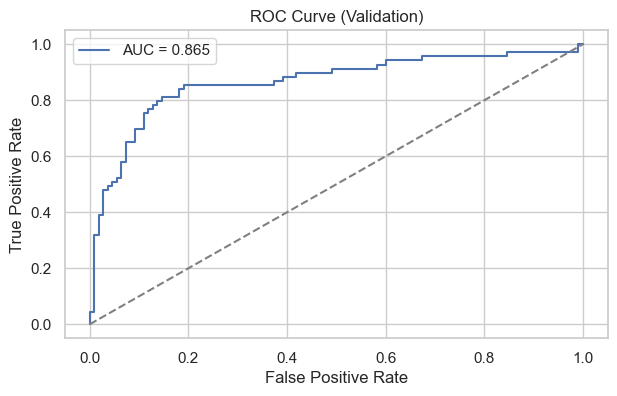

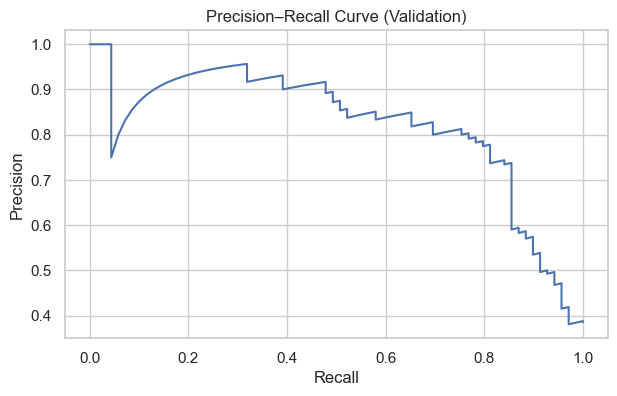

In [18]:
# ============================================================
# 13. Threshold analysis – Precision-Recall and ROC
# ============================================================

# ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_proba)
auc = roc_auc_score(y_val, y_val_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.show()

# Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation)")
plt.show()

In [28]:
fn = val_results[val_results["error_type"] == "FN"]

In [26]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
fn

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeMissing,TicketPrefix,FareMissing,CabinKnown,CabinDeck,FamilySize,IsAlone,LogFare,FarePerPerson,TicketGroupSize,TicketGroupFarePerPerson,AgeBand,FareBand,Sex_Pclass,Sex_AgeBand,Embarked_Pclass,Title_AgeBand,Pclass_FareBand,y_true,y_pred,y_proba,error_type
553,3,male,22.0,0,0,7.2250,C,Mr,0,NONE,0,0,Unknown,1,1,2.107178,7.225000,1,7.2250,"(20.0, 25.0]","(-0.001, 7.854]",male_3,"male_(20.0, 25.0]",C_3,"Mr_(20.0, 25.0]","3_(-0.001, 7.854]",1,0,0.118466,FN
712,1,male,48.0,1,0,52.0000,S,Mr,0,NONE,0,1,C,2,0,3.970292,26.000000,2,26.0000,"(40.0, 80.0]","(39.688, 512.329]",male_1,"male_(40.0, 80.0]",S_1,"Mr_(40.0, 80.0]","1_(39.688, 512.329]",1,0,0.181504,FN
455,3,male,29.0,0,0,7.8958,C,Mr,0,NONE,0,0,Unknown,1,1,2.185579,7.895800,1,7.8958,"(25.0, 30.0]","(7.854, 10.5]",male_3,"male_(25.0, 30.0]",C_3,"Mr_(25.0, 30.0]","3_(7.854, 10.5]",1,0,0.188885,FN
65,3,male,25.0,1,1,15.2458,C,Master,1,NONE,0,0,Unknown,3,0,2.787834,5.081933,2,7.6229,"(20.0, 25.0]","(10.5, 21.679]",male_3,"male_(20.0, 25.0]",C_3,"Master_(20.0, 25.0]","3_(10.5, 21.679]",1,0,0.469853,FN
17,2,male,30.0,0,0,13.0000,S,Mr,1,NONE,0,0,Unknown,1,1,2.639057,13.000000,1,13.0000,"(25.0, 30.0]","(10.5, 21.679]",male_2,"male_(25.0, 30.0]",S_2,"Mr_(25.0, 30.0]","2_(10.5, 21.679]",1,0,0.120231,FN
447,1,male,34.0,0,0,26.5500,S,Mr,0,NONE,0,0,Unknown,1,1,3.316003,26.550000,1,26.5500,"(30.0, 40.0]","(21.679, 39.688]",male_1,"male_(30.0, 40.0]",S_1,"Mr_(30.0, 40.0]","1_(21.679, 39.688]",1,0,0.339473,FN
690,1,male,31.0,1,0,57.0000,S,Mr,0,NONE,0,1,B,2,0,4.060443,28.500000,2,28.5000,"(30.0, 40.0]","(39.688, 512.329]",male_1,"male_(30.0, 40.0]",S_1,"Mr_(30.0, 40.0]","1_(39.688, 512.329]",1,0,0.477499,FN
55,1,male,40.0,0,0,35.5000,S,Mr,1,NONE,0,1,C,1,1,3.597312,35.500000,1,35.5000,"(30.0, 40.0]","(21.679, 39.688]",male_1,"male_(30.0, 40.0]",S_1,"Mr_(30.0, 40.0]","1_(21.679, 39.688]",1,0,0.438540,FN
570,2,male,62.0,0,0,10.5000,S,Mr,0,S,0,0,Unknown,1,1,2.442347,10.500000,1,10.5000,"(40.0, 80.0]","(7.854, 10.5]",male_2,"male_(40.0, 80.0]",S_2,"Mr_(40.0, 80.0]","2_(7.854, 10.5]",1,0,0.004636,FN
271,3,male,25.0,0,0,0.0000,S,Mr,0,OTHER,0,0,Unknown,1,1,0.000000,0.000000,4,0.0000,"(20.0, 25.0]","(-0.001, 7.854]",male_3,"male_(20.0, 25.0]",S_3,"Mr_(20.0, 25.0]","3_(-0.001, 7.854]",1,0,0.008338,FN


In [27]:
fp = val_results[val_results["error_type"] == "FP"]

In [29]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
fp

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeMissing,TicketPrefix,FareMissing,CabinKnown,CabinDeck,FamilySize,IsAlone,LogFare,FarePerPerson,TicketGroupSize,TicketGroupFarePerPerson,AgeBand,FareBand,Sex_Pclass,Sex_AgeBand,Embarked_Pclass,Title_AgeBand,Pclass_FareBand,y_true,y_pred,y_proba,error_type
536,1,male,45.0,0,0,26.5500,S,Rare,0,NONE,0,1,B,1,1,3.316003,26.550000,1,26.550000,"(40.0, 80.0]","(21.679, 39.688]",male_1,"male_(40.0, 80.0]",S_1,"Rare_(40.0, 80.0]","1_(21.679, 39.688]",0,1,0.793463,FP
297,1,female,2.0,1,2,151.5500,S,Miss,0,NONE,0,1,C,4,0,5.027492,37.887500,4,37.887500,"(0.419, 20.0]","(39.688, 512.329]",female_1,"female_(0.419, 20.0]",S_1,"Miss_(0.419, 20.0]","1_(39.688, 512.329]",0,1,0.991420,FP
564,3,female,21.5,0,0,8.0500,S,Miss,1,SOTON,0,0,Unknown,1,1,2.202765,8.050000,1,8.050000,"(20.0, 25.0]","(7.854, 10.5]",female_3,"female_(20.0, 25.0]",S_3,"Miss_(20.0, 25.0]","3_(7.854, 10.5]",0,1,0.577023,FP
502,3,female,21.5,0,0,7.6292,Q,Miss,1,NONE,0,0,Unknown,1,1,2.155152,7.629200,1,7.629200,"(20.0, 25.0]","(-0.001, 7.854]",female_3,"female_(20.0, 25.0]",Q_3,"Miss_(20.0, 25.0]","3_(-0.001, 7.854]",0,1,0.764939,FP
578,3,female,21.5,1,0,14.4583,C,Mrs,1,NONE,0,0,Unknown,2,0,2.738146,7.229150,1,14.458300,"(20.0, 25.0]","(10.5, 21.679]",female_3,"female_(20.0, 25.0]",C_3,"Mrs_(20.0, 25.0]","3_(10.5, 21.679]",0,1,0.719734,FP
593,3,female,21.5,0,2,7.7500,Q,Miss,1,NONE,0,0,Unknown,3,0,2.169054,2.583333,1,7.750000,"(20.0, 25.0]","(-0.001, 7.854]",female_3,"female_(20.0, 25.0]",Q_3,"Miss_(20.0, 25.0]","3_(-0.001, 7.854]",0,1,0.759965,FP
386,3,male,1.0,5,2,46.9000,S,Master,0,CA,0,0,Unknown,8,0,3.869116,5.862500,6,7.816667,"(0.419, 20.0]","(39.688, 512.329]",male_3,"male_(0.419, 20.0]",S_3,"Master_(0.419, 20.0]","3_(39.688, 512.329]",0,1,0.538300,FP
501,3,female,21.0,0,0,7.7500,Q,Miss,0,NONE,0,0,Unknown,1,1,2.169054,7.750000,1,7.750000,"(20.0, 25.0]","(-0.001, 7.854]",female_3,"female_(20.0, 25.0]",Q_3,"Miss_(20.0, 25.0]","3_(-0.001, 7.854]",0,1,0.739114,FP
452,1,male,30.0,0,0,27.7500,C,Mr,0,NONE,0,1,C,1,1,3.358638,27.750000,1,27.750000,"(25.0, 30.0]","(21.679, 39.688]",male_1,"male_(25.0, 30.0]",C_1,"Mr_(25.0, 30.0]","1_(21.679, 39.688]",0,1,0.601659,FP
245,1,male,44.0,2,0,90.0000,Q,Rare,0,NONE,0,1,C,3,0,4.510860,30.000000,2,45.000000,"(40.0, 80.0]","(39.688, 512.329]",male_1,"male_(40.0, 80.0]",Q_1,"Rare_(40.0, 80.0]","1_(39.688, 512.329]",0,1,0.662997,FP


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("../data/processed_v2/train_features.csv")
test  = pd.read_csv("../data/processed_v2/test_features.csv")

In [31]:
combined = pd.concat([train.drop(columns=["Survived"]), test], axis=0, ignore_index=True)

In [32]:
title_counts = combined["Title"].value_counts().sort_values(ascending=False)
title_counts

Title
Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: count, dtype: int64

In [33]:
title_percent = combined["Title"].value_counts(normalize=True).sort_values(ascending=False) * 100
title_percent

Title
Mr        57.830405
Miss      20.168067
Mrs       15.126050
Master     4.660046
Rare       2.215432
Name: proportion, dtype: float64

C:\Users\agbro\AppData\Local\Temp\ipykernel_24548\316163735.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=title_counts.index, y=title_counts.values, palette="tab10")


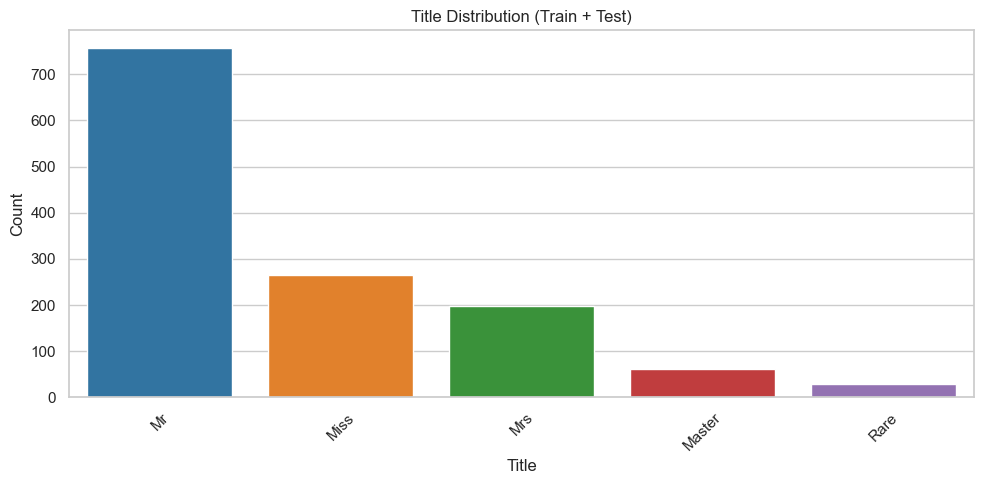

In [34]:
plt.figure(figsize=(10, 5))
sns.barplot(x=title_counts.index, y=title_counts.values, palette="tab10")
plt.title("Title Distribution (Train + Test)")
plt.ylabel("Count")
plt.xlabel("Title")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()